In [1]:
import random
from datasets import load_dataset
from torch.cuda.amp import autocast, GradScaler
from rnd import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# --- 1. Config ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
ENCODER_NAME = "Alibaba-NLP/gte-modernbert-base"
NUM_TRAIN_SAMPLES = 1000
NUM_TEST_SAMPLES = 200
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4
BATCH_SIZE = 50  # Process data in smaller batches to avoid OOM

# --- 2. Load Dataset ---
print(f"Loading DeepMath dataset (first {NUM_TRAIN_SAMPLES + NUM_TEST_SAMPLES} samples)...")
dataset = load_dataset("zwhe99/DeepMath-103K", split="train")
dataset = dataset.shuffle(seed=42)

train_data = dataset.select(range(NUM_TRAIN_SAMPLES))
test_data = dataset.select(range(NUM_TRAIN_SAMPLES, NUM_TRAIN_SAMPLES + NUM_TEST_SAMPLES))

# --- 3. Initialize Model and Optimizer ---
print("\nInitializing SemanticRND...")
semantic_rnd = SemanticRND(
    encoder_model_name=ENCODER_NAME,
    rnd_output_dim=64,
    rnd_hidden_dim=8,
    device=DEVICE,
    max_length=512,
    concat_problem_answer=True
).to(DEVICE)

print(f"✓ Model initialized on {DEVICE}")
print(f"✓ Batch size set to {BATCH_SIZE} samples")


Loading DeepMath dataset (first 1200 samples)...

Initializing SemanticRND...
[SemanticRND] Initializing encoder: Alibaba-NLP/gte-modernbert-base
[Encoder] loading model 'Alibaba-NLP/gte-modernbert-base' on device=cuda ...

Initializing SemanticRND...
[SemanticRND] Initializing encoder: Alibaba-NLP/gte-modernbert-base
[Encoder] loading model 'Alibaba-NLP/gte-modernbert-base' on device=cuda ...


d:\Programs\miniconda3\envs\deepRLclm\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


[Encoder] loaded (embedding_dim=768)
[SemanticRND] Encoder frozen (requires_grad=False)
[SemanticRND] Encoding concatenated problem+answer (input_dim=768)
[SemanticRND] Initializing RND module
[SemanticRND] Initialization complete!
✓ Model initialized on cuda
✓ Batch size set to 50 samples


In [3]:

optimizer = torch.optim.Adam(semantic_rnd.predictor_parameters(), lr=LEARNING_RATE)
scaler = GradScaler()
print("✓ Optimizer initialized.")

# --- 4. Training Loop ---
print(f"\nTraining RND for {NUM_EPOCHS} epochs on {NUM_TRAIN_SAMPLES} samples...")
print(f"Processing in batches of {BATCH_SIZE} samples\n")

# Track training loss for plotting
training_losses = []

for epoch in range(NUM_EPOCHS):
    semantic_rnd.train()
    epoch_losses = []
    
    # Process data in batches to avoid OOM
    num_batches = (NUM_TRAIN_SAMPLES + BATCH_SIZE - 1) // BATCH_SIZE
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, NUM_TRAIN_SAMPLES)
        
        # Create batch of groups for this mini-batch
        batch_of_groups = []
        for i in range(start_idx, end_idx):
            item = train_data[i]
            group = [
                (item['question'], item['r1_solution_1']),
                (item['question'], item['r1_solution_2'])
            ]
            batch_of_groups.append(group)
        
        # Forward pass with mixed precision
        with autocast():
            _, loss = semantic_rnd(batch_of_groups, update_stats=True)
        
        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        epoch_losses.append(loss.item())
        
        # Clear cache to free memory
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
    
    # Average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    training_losses.append(avg_epoch_loss)
    
    # Print every 5 epochs or first/last epoch
    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Avg Loss: {avg_epoch_loss:.8f} (across {num_batches} batches)")

print("\n✓ Training complete!")


C:\Users\spand\AppData\Local\Temp\ipykernel_37704\1348877697.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\spand\AppData\Local\Temp\ipykernel_37704\1348877697.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✓ Optimizer initialized.

Training RND for 50 epochs on 1000 samples...
Processing in batches of 50 samples

Epoch 1/50, Avg Loss: 0.08572285 (across 20 batches)
Epoch 1/50, Avg Loss: 0.08572285 (across 20 batches)
Epoch 5/50, Avg Loss: 0.07913617 (across 20 batches)
Epoch 5/50, Avg Loss: 0.07913617 (across 20 batches)
Epoch 10/50, Avg Loss: 0.06915765 (across 20 batches)
Epoch 10/50, Avg Loss: 0.06915765 (across 20 batches)
Epoch 15/50, Avg Loss: 0.05855746 (across 20 batches)
Epoch 15/50, Avg Loss: 0.05855746 (across 20 batches)
Epoch 20/50, Avg Loss: 0.04750536 (across 20 batches)
Epoch 20/50, Avg Loss: 0.04750536 (across 20 batches)
Epoch 25/50, Avg Loss: 0.03701365 (across 20 batches)
Epoch 25/50, Avg Loss: 0.03701365 (across 20 batches)
Epoch 30/50, Avg Loss: 0.02866048 (across 20 batches)
Epoch 30/50, Avg Loss: 0.02866048 (across 20 batches)
Epoch 35/50, Avg Loss: 0.02225162 (across 20 batches)
Epoch 35/50, Avg Loss: 0.02225162 (across 20 batches)
Epoch 40/50, Avg Loss: 0.017350

In [4]:

# --- 5. Testing Phase ---
print("\n--- Testing RND Rewards ---")
print(f"Processing {NUM_TRAIN_SAMPLES} test samples in batches of {BATCH_SIZE}...")
semantic_rnd.eval()

# Prepare data
questions = list(train_data['question'])
solutions_1 = list(train_data['r1_solution_1'])
solutions_3 = list(train_data['r1_solution_3'])

# Create a "random solution" list by shuffling solutions_1
random_solutions = random.sample(solutions_1, len(solutions_1))

# Store all rewards (will collect batch by batch)
all_rewards_s1 = []
all_rewards_s3 = []
all_rewards_rand = []

# Process in batches to avoid OOM
num_test_batches = (NUM_TRAIN_SAMPLES + BATCH_SIZE - 1) // BATCH_SIZE

with torch.no_grad():
    for batch_idx in range(num_test_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, NUM_TRAIN_SAMPLES)
        
        # Create test batches for this chunk
        test_batch_s1 = []
        test_batch_s3 = []
        test_batch_rand = []
        
        for i in range(start_idx, end_idx):
            test_batch_s1.append([(questions[i], solutions_1[i])])
            test_batch_s3.append([(questions[i], solutions_3[i])])
            test_batch_rand.append([(questions[i], random_solutions[i])])
        
        # Get rewards for this batch (no stat updates during testing)
        rewards_s1, _ = semantic_rnd(test_batch_s1, update_stats=False)
        rewards_s3, _ = semantic_rnd(test_batch_s3, update_stats=False)
        rewards_rand, _ = semantic_rnd(test_batch_rand, update_stats=False)
        
        # Handle both tensor and list cases
        if isinstance(rewards_s1, torch.Tensor):
            all_rewards_s1.append(rewards_s1.flatten().cpu())
            all_rewards_s3.append(rewards_s3.flatten().cpu())
            all_rewards_rand.append(rewards_rand.flatten().cpu())
        else:
            all_rewards_s1.append(torch.cat(rewards_s1).cpu())
            all_rewards_s3.append(torch.cat(rewards_s3).cpu())
            all_rewards_rand.append(torch.cat(rewards_rand).cpu())
        
        # Clear cache
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
        
        # Progress indicator
        if (batch_idx + 1) % 5 == 0 or batch_idx == num_test_batches - 1:
            print(f"  Processed {end_idx}/{NUM_TRAIN_SAMPLES} samples...")

# Concatenate all batch results
all_rewards_s1 = torch.cat(all_rewards_s1)
all_rewards_s3 = torch.cat(all_rewards_s3)
all_rewards_rand = torch.cat(all_rewards_rand)

# Calculate statistics
mean_reward_s1 = all_rewards_s1.mean().item()
mean_reward_s3 = all_rewards_s3.mean().item()
mean_reward_rand = all_rewards_rand.mean().item()

std_reward_s1 = all_rewards_s1.std().item()
std_reward_s3 = all_rewards_s3.std().item()
std_reward_rand = all_rewards_rand.std().item()

# Calculate ratios to quantify novelty detection
ratio_unseen_vs_seen = mean_reward_s3 / (mean_reward_s1 + 1e-8)
ratio_random_vs_seen = mean_reward_rand / (mean_reward_s1 + 1e-8)
ratio_unseen_vs_random = mean_reward_s3 / (mean_reward_rand + 1e-8)

# --- 6. Print Results ---
print("\n" + "="*70)
print(" EXPERIMENT RESULTS: RND Intrinsic Reward Analysis")
print("="*70)

print("\n📊 Average Intrinsic Rewards:")
print(f"  Trained Solutions (Sol 1): {mean_reward_s1:.6f} ± {std_reward_s1:.6f}  (Expected: LOW)")
print(f"  Unseen Path (Sol 3):       {mean_reward_s3:.6f} ± {std_reward_s3:.6f}  (Expected: HIGH)")
print(f"  Random Solution (Control): {mean_reward_rand:.6f} ± {std_reward_rand:.6f}  (Expected: HIGH)")

print("\n📈 Reward Ratios (Higher = Better Novelty Detection):")
print(f"  Unseen / Seen:   {ratio_unseen_vs_seen:.3f}x")
print(f"  Random / Seen:   {ratio_random_vs_seen:.3f}x")
print(f"  Unseen / Random: {ratio_unseen_vs_random:.3f}x")

print("\n💡 Interpretation:")
if ratio_unseen_vs_seen > 1.5:
    print("  ✓ Strong novelty detection: RND successfully learned to distinguish seen solutions!")
elif ratio_unseen_vs_seen > 1.1:
    print("  ~ Moderate novelty detection: RND shows some learning but could be stronger.")
else:
    print("  ✗ Weak novelty detection: RND hasn't learned to distinguish solutions well.")

if ratio_unseen_vs_random > 0.9 and ratio_unseen_vs_random < 1.1:
    print("  ✓ Both unseen and random solutions are equally novel (expected behavior).")
elif ratio_unseen_vs_random > 1.2:
    print("  ~ Unseen solutions are MORE novel than random (interesting finding!).")
else:
    print("  ~ Random solutions are MORE novel than unseen (unexpected - may need more training).")

print("="*70)
print("\nExperiment complete.")



--- Testing RND Rewards ---
Processing 1000 test samples in batches of 50...
  Processed 250/1000 samples...
  Processed 250/1000 samples...
  Processed 500/1000 samples...
  Processed 500/1000 samples...
  Processed 750/1000 samples...
  Processed 750/1000 samples...
  Processed 1000/1000 samples...

 EXPERIMENT RESULTS: RND Intrinsic Reward Analysis

📊 Average Intrinsic Rewards:
  Trained Solutions (Sol 1): -1.289520 ± 0.017543  (Expected: LOW)
  Unseen Path (Sol 3):       -1.289771 ± 0.016844  (Expected: HIGH)
  Random Solution (Control): -1.283311 ± 0.018809  (Expected: HIGH)

📈 Reward Ratios (Higher = Better Novelty Detection):
  Unseen / Seen:   1.000x
  Random / Seen:   0.995x
  Unseen / Random: 1.005x

💡 Interpretation:
  ✗ Weak novelty detection: RND hasn't learned to distinguish solutions well.
  ✓ Both unseen and random solutions are equally novel (expected behavior).

Experiment complete.
  Processed 1000/1000 samples...

 EXPERIMENT RESULTS: RND Intrinsic Reward Analysis



📊 Generating training curves...
✓ Plot saved as 'rnd_experiment_results.png'
✓ Plot saved as 'rnd_experiment_results.png'


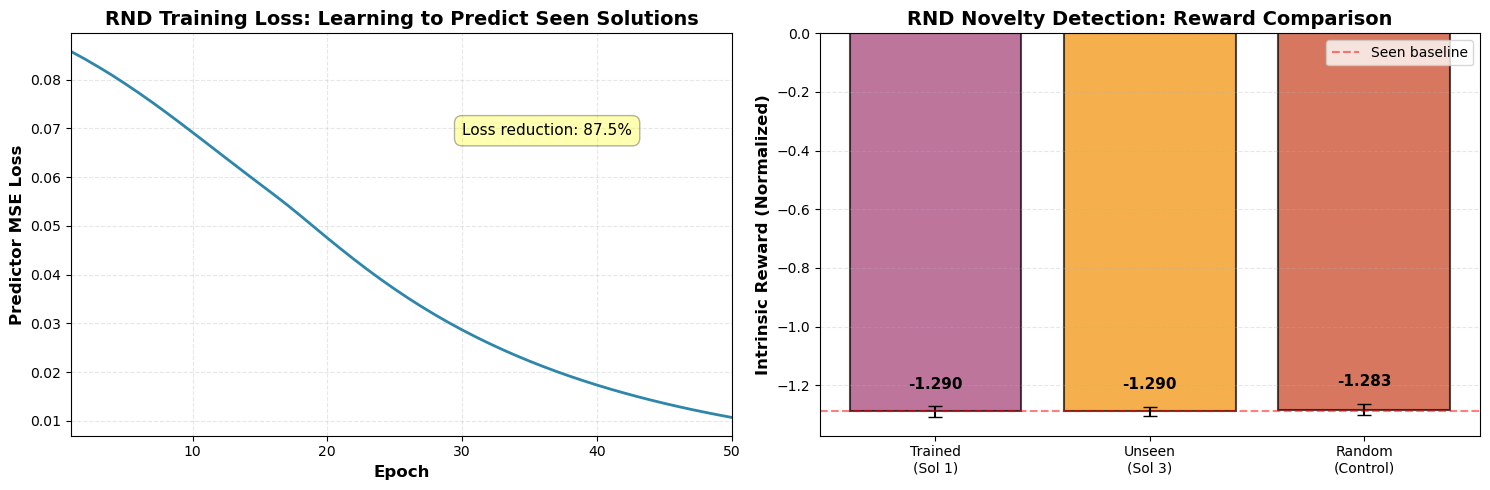


📉 Training Convergence Analysis:
  Initial Loss:     0.085723
  Final Loss:       0.010707
  Loss Reduction:   87.51%
  Status: ~ Still learning (loss varying, σ=0.001854, consider more epochs)


In [5]:
# --- 7. Visualization: Training Dynamics ---
print("\n📊 Generating training curves...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss Curve
axes[0].plot(range(1, NUM_EPOCHS + 1), training_losses, linewidth=2, color='#2E86AB')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predictor MSE Loss', fontsize=12, fontweight='bold')
axes[0].set_title('RND Training Loss: Learning to Predict Seen Solutions', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_xlim(1, NUM_EPOCHS)

# Add annotation for loss drop
if len(training_losses) > 1:
    initial_loss = training_losses[0]
    final_loss = training_losses[-1]
    loss_reduction = ((initial_loss - final_loss) / initial_loss) * 100
    axes[0].annotate(f'Loss reduction: {loss_reduction:.1f}%', 
                     xy=(NUM_EPOCHS * 0.6, max(training_losses) * 0.8),
                     fontsize=11, 
                     bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

# Plot 2: Reward Comparison Bar Chart
categories = ['Trained\n(Sol 1)', 'Unseen\n(Sol 3)', 'Random\n(Control)']
means = [mean_reward_s1, mean_reward_s3, mean_reward_rand]
stds = [std_reward_s1, std_reward_s3, std_reward_rand]
colors = ['#A23B72', '#F18F01', '#C73E1D']

bars = axes[1].bar(categories, means, yerr=stds, capsize=5, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Intrinsic Reward (Normalized)', fontsize=12, fontweight='bold')
axes[1].set_title('RND Novelty Detection: Reward Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--', axis='y')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + std + 0.05,
                f'{mean:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add horizontal line for reference
axes[1].axhline(y=mean_reward_s1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Seen baseline')
axes[1].legend()

plt.tight_layout()
plt.savefig('rnd_experiment_results.png', dpi=150, bbox_inches='tight')
print("✓ Plot saved as 'rnd_experiment_results.png'")
plt.show()

# Print convergence analysis
print("\n📉 Training Convergence Analysis:")
print(f"  Initial Loss:     {training_losses[0]:.6f}")
print(f"  Final Loss:       {training_losses[-1]:.6f}")
print(f"  Loss Reduction:   {loss_reduction:.2f}%")

if len(training_losses) >= 10:
    # Check if loss plateaued (last 20% of training)
    plateau_start = int(NUM_EPOCHS * 0.8)
    plateau_losses = training_losses[plateau_start:]
    plateau_std = np.std(plateau_losses)
    
    if plateau_std < 0.001:
        print(f"  Status: ✓ Converged (loss stable in final 20% of training, σ={plateau_std:.6f})")
    else:
        print(f"  Status: ~ Still learning (loss varying, σ={plateau_std:.6f}, consider more epochs)")
